## **Week 12 AMZN Technical Factor Test**

### **Import Libraries**

In [1]:
# import needed libraries
import numpy as np
from numpy import loadtxt
from pandas_datareader import data, wb
import datetime
import holidays
from dateutil.relativedelta import relativedelta
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


### **Data Preprocessing**
Input data from CSV file, and remove non-quintile and missing value factors 

In [2]:
def data_preparation(path):
    '''
    This function is to prepare the techinical factors dataframe by removing the non-rank columns and columns containing missing data.
    '''
    factor_df = pd.read_csv(path)
    # remove non-rank columns 
    columns = factor_df.columns.drop(['End of Month', 'PERMNO', 'GVKEY', 'Point-in-time CUSIP', 'Point-in-time Ticker', 'Point-in-time Name', 'Last Known CUSIP', 'Last Known Ticker', 'Last Known Name'])
    factor_df = factor_df[columns]
    
    # Convert CalendarDate into datatime format
    factor_df['Date'] =  pd.to_datetime(factor_df['Calendar Date'], format='%Y%m%d')
    factor_df = factor_df.drop(['Calendar Date'], axis=1)
    # create a new dataframe with 'CalendarDate' column as index
    factor_df = factor_df.set_index('Date')
    
    # handling missing data
    factor_df[factor_df=='.'] = pd.np.nan 
    factor_df = factor_df.astype(float)
    
    # remove columns contains nan
    factor_df = factor_df.dropna(axis=1, how='any')
      
    return factor_df
    
AMZN_tech_factor_df = data_preparation('tech_factor_data/AMZN_tech_inputs_daily_quintile_ranks_s2000.csv')
AMZN_tech_factor_df.head()

,One-Week Daily Price Trend,One-Month Daily Price Trend,Three-Month Daily Price Trend,Nine-Month Daily Price Trend,Nine-Month Daily Return Skewness,Nine-Month Share of Days Outperforming,Average Daily Share Turnover,One-Month Change in Average Daily Share Turnover,Stochastic Oscillator,Relative Strength Index,...,Arbitrage Risk,One-Month Change in Arbitrage Risk,Daily Media Sentiment Indicator,Downside Risk (Measured Over the Trailing Three Months),Downside Risk (Measured Over the Trailing Six Months),Downside Risk (Measured Over the Trailing Nine Months),Downside Risk (Measured Over the Trailing Twelve Months),Change in Downside Risk (Measured Over the Trailing Twelve Months),Interaction of Supernovas and Nine-Month Price Trend,Interaction of Earnings Growth Stability and Arbitrage Risk
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5.0,5.0,3.0,3.0,3.0,2.0,5.0,1.0,1.0,1.0,...,5.0,4.0,4.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0
2000-01-04,1.0,2.0,2.0,2.0,3.0,2.0,5.0,1.0,2.0,2.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0
2000-01-05,2.0,3.0,3.0,2.0,3.0,2.0,5.0,1.0,2.0,1.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-06,5.0,5.0,5.0,3.0,3.0,2.0,5.0,2.0,1.0,1.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-07,5.0,5.0,5.0,4.0,3.0,2.0,5.0,2.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [3]:
AMZN_tech_factor_df.columns

Index(['One-Week Daily Price Trend', 'One-Month Daily Price Trend',
       'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend',
       'Nine-Month Daily Return Skewness',
       'Nine-Month Share of Days Outperforming',
       'Average Daily Share Turnover',
       'One-Month Change in Average Daily Share Turnover',
       'Stochastic Oscillator', 'Relative Strength Index', 'Bollinger Band',
       'MACD Signal', 'Technical Indicator', 'Earnings Revision',
       'Three-Month Smoothed Earnings Revision', 'Estimate Dispersion',
       'Share of Estimates Rising', 'Three-Month Smoothed Dollar Volume',
       'Arbitrage Risk', 'One-Month Change in Arbitrage Risk',
       'Daily Media Sentiment Indicator',
       'Downside Risk (Measured Over the Trailing Three Months)',
       'Downside Risk (Measured Over the Trailing Six Months)',
       'Downside Risk (Measured Over the Trailing Nine Months)',
       'Downside Risk (Measured Over the Trailing Twelve Months)',
       'Change

### **Variance Test for Technical Factors**
feature selection based on the feature variance based on the assumption that high variance means factor conatain more active information
+ This is one approach to select factors, but I haven't used it in this test. Instead, I choose some factors based on the paper I read mannually. 

In [4]:
var_thres = 0.2
def variance_feature_selection(factor_df, var_thres):
    '''
    This function is to show the variace for each factors and sort them,
    also select the factors with variance above the threshold.
    '''
    selector = VarianceThreshold(var_thres)
    fit = selector.fit_transform(factor_df)
    dfvariances = pd.DataFrame(selector.variances_)
    dfcolumns = pd.DataFrame(factor_df.columns)
    #concat two dataframes for better visualization 
    featureVariances = pd.concat([dfcolumns,dfvariances],axis=1)
    featureVariances.columns = ['Factor','Variance']  #naming the dataframe columns
    print(featureVariances.nlargest(34,'Variance'))  #print 10 best features
     
    return factor_df[factor_df.columns[selector.get_support(indices=True)]]

var_AMZN_tech_factor_df = variance_feature_selection(AMZN_tech_factor_df, var_thres)
var_AMZN_tech_factor_df.head() 

                                               Factor  Variance
2                       Three-Month Daily Price Trend  2.585735
11                                        MACD Signal  2.489928
4                    Nine-Month Daily Return Skewness  2.423347
1                         One-Month Daily Price Trend  2.415757
0                          One-Week Daily Price Trend  2.414388
20                    Daily Media Sentiment Indicator  2.363144
19                 One-Month Change in Arbitrage Risk  2.361697
25  Change in Downside Risk (Measured Over the Tra...  2.349868
3                        Nine-Month Daily Price Trend  2.321201
12                                Technical Indicator  2.171795
6                        Average Daily Share Turnover  2.108665
9                             Relative Strength Index  2.103691
8                               Stochastic Oscillator  2.056503
7    One-Month Change in Average Daily Share Turnover  1.964721
16                          Share of Est

,One-Week Daily Price Trend,One-Month Daily Price Trend,Three-Month Daily Price Trend,Nine-Month Daily Price Trend,Nine-Month Daily Return Skewness,Nine-Month Share of Days Outperforming,Average Daily Share Turnover,One-Month Change in Average Daily Share Turnover,Stochastic Oscillator,Relative Strength Index,...,Arbitrage Risk,One-Month Change in Arbitrage Risk,Daily Media Sentiment Indicator,Downside Risk (Measured Over the Trailing Three Months),Downside Risk (Measured Over the Trailing Six Months),Downside Risk (Measured Over the Trailing Nine Months),Downside Risk (Measured Over the Trailing Twelve Months),Change in Downside Risk (Measured Over the Trailing Twelve Months),Interaction of Supernovas and Nine-Month Price Trend,Interaction of Earnings Growth Stability and Arbitrage Risk
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5.0,5.0,3.0,3.0,3.0,2.0,5.0,1.0,1.0,1.0,...,5.0,4.0,4.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0
2000-01-04,1.0,2.0,2.0,2.0,3.0,2.0,5.0,1.0,2.0,2.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0
2000-01-05,2.0,3.0,3.0,2.0,3.0,2.0,5.0,1.0,2.0,1.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-06,5.0,5.0,5.0,3.0,3.0,2.0,5.0,2.0,1.0,1.0,...,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-07,5.0,5.0,5.0,4.0,3.0,2.0,5.0,2.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


### **Technical Factor Selection**

1. **Technical Indicator：** An optimal combination of the four factors, `RSI`, `Stochastic Oscillator`, `MACD`, and `Bollinger Band`. 
+ **Moving Average Convergence Divergence (MACD):** When the `MACD` goes below the `SignalLine`, it indicates a sell signal. When it goes above the `SignalLine`, it indicates a buy signal. 
+ **Stochastic Oscillator:** It refers to the point of a current price in  relation to its price range over a period of time. This methold attempts to predict prices turning points by comparing the closing price of a security to its price range. 
+ **One-Week Daily Price Trend:** It measures the most recent change in price with respect to the price in n days ago.
+ **Relative Strength Index (RSI):** It examines price strength by comparing upward and downward daily movements. The principle is that when there's a high proportion of daily movement in one direction it suggests an extreme, prices are likely to reverse.
+ **One-Month Change in Average Daily Share Turnover:** Total trading volume normalized by total shares outstanding over the past 189 trading days.

In [5]:
var_AMZN_tech_factor_df = variance_feature_selection(AMZN_tech_factor_df, var_thres)

                                               Factor  Variance
2                       Three-Month Daily Price Trend  2.585735
11                                        MACD Signal  2.489928
4                    Nine-Month Daily Return Skewness  2.423347
1                         One-Month Daily Price Trend  2.415757
0                          One-Week Daily Price Trend  2.414388
20                    Daily Media Sentiment Indicator  2.363144
19                 One-Month Change in Arbitrage Risk  2.361697
25  Change in Downside Risk (Measured Over the Tra...  2.349868
3                        Nine-Month Daily Price Trend  2.321201
12                                Technical Indicator  2.171795
6                        Average Daily Share Turnover  2.108665
9                             Relative Strength Index  2.103691
8                               Stochastic Oscillator  2.056503
7    One-Month Change in Average Daily Share Turnover  1.964721
16                          Share of Est

In [6]:
sns.set_context('notebook', font_scale=2)

def plot_one_column(df, column_name):
    '''
    This function is to plot the time seies trend for one factor in the dataframe 
    '''
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    gx.plot(df.index, df[column_name], color='blue', label=column_name)
    gx.set_xlabel('Dates',size=40, fontsize=40)
#     gx.set_ylabel('Quintile Rank', fontsize=20)
    gx.set_title(column_name, size=40)
    # other parameters
    gx.grid(True)

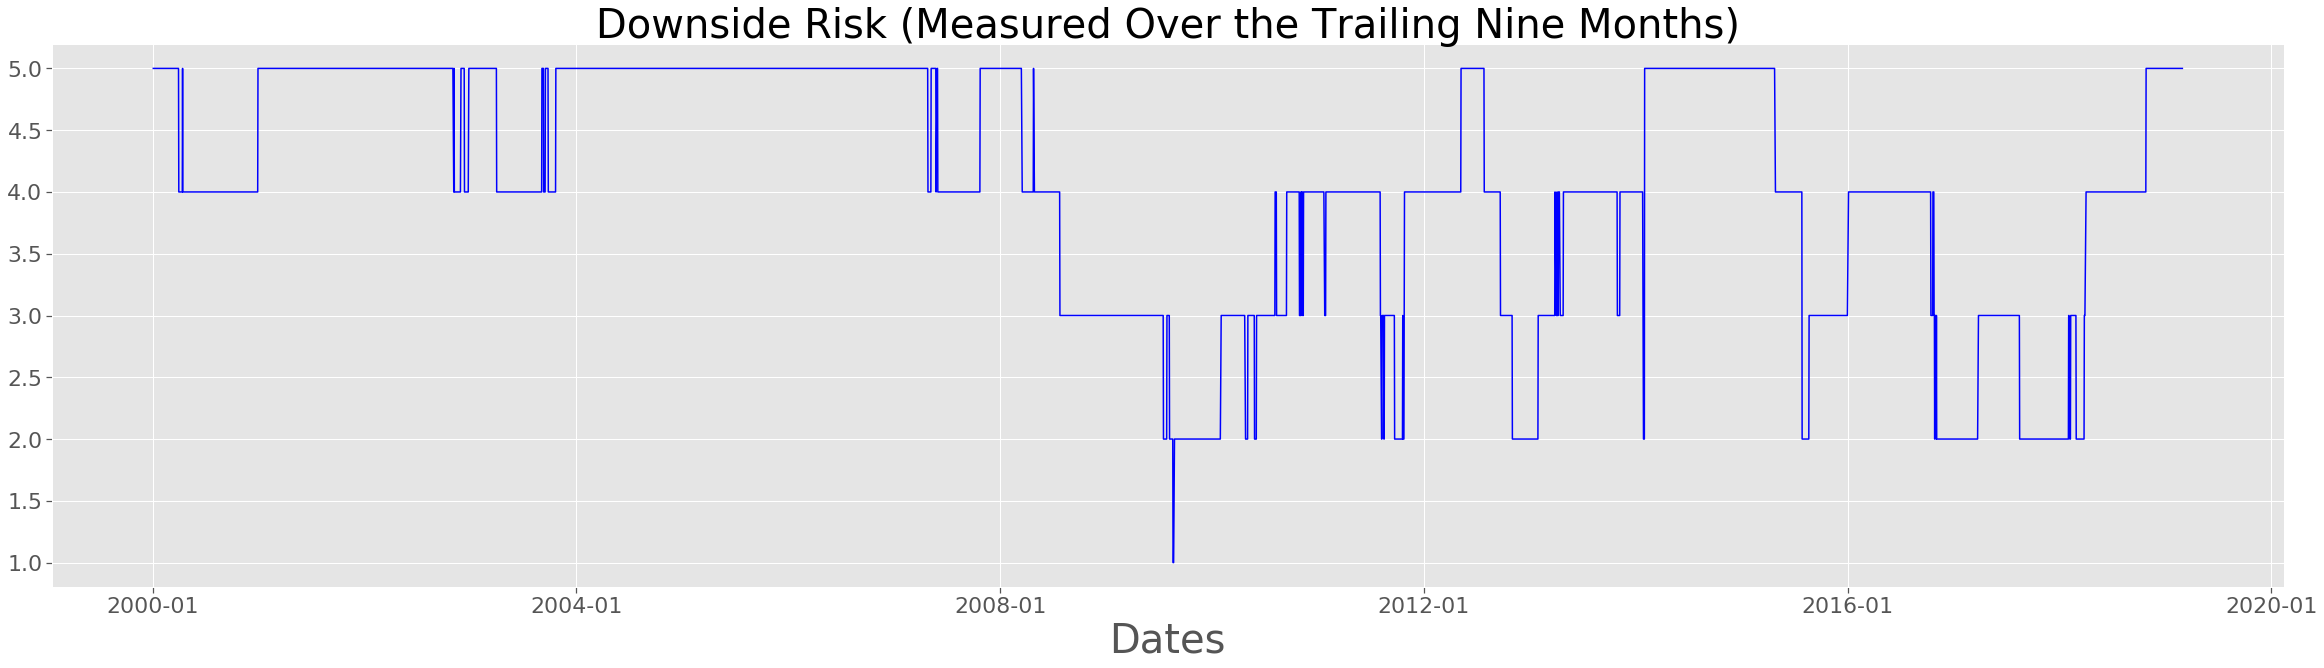

In [7]:
plot_one_column(AMZN_tech_factor_df,'Downside Risk (Measured Over the Trailing Nine Months)')

### **Function to Generate real-time labels**

In [44]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

# function to return the date of n bussiness days before the test date 
def n_business_day_before(test_date, n):
    '''
    This function is a helper function trying to calculate the date that n business day before the input date
    '''
    last_day = test_date
    for _ in range(n):
        last_day = last_day - ONE_DAY
        while last_day.weekday() in holidays.WEEKEND or last_day in HOLIDAYS_US:
            last_day -= ONE_DAY
    return last_day 

def up_down_threshold(df, train_start_date, test_date, pred_day):
    '''
    This function is to calcuate the up and down tresholds for balanced input labels in the ML system 
    date ranging from train_start_date to train_end_date.
    inputs:
    df: dataframe contains ReturnNDays column
    ''' 
    train_end_date = n_business_day_before(test_date, pred_day)
    dataset_mask = (df.index>=train_start_date) & (df.index<=train_end_date)
    return_list = df['Return{}Days'.format(pred_day)].loc[dataset_mask].tolist()
    sorted_return_list = sorted(return_list, key=float)
#     print(sorted_return_list)
    down_thres_index = int(len(sorted_return_list)/3 + 1)
    up_thres_index = down_thres_index * 2 
    down_thres, up_thres = sorted_return_list[down_thres_index], sorted_return_list[up_thres_index]
    return down_thres, up_thres

def generate_NDayReturn(factor_df, ticker_name, start_date, end_date, pred_day):
    '''
    This function is to generate the n days return column by downloading stock price data from Yahoo Finance
    and calculate the percentage change based on predicted days.
    input:
    factor_df: dataframe containing only tech factors 
    '''
    price_df = data.DataReader(ticker_name, 'yahoo', start_date, end_date)
    price_df = price_df[['Adj Close']]
    df = pd.merge(factor_df, price_df, on='Date')

    # obtain n day return percent in the future 
    df['Return{}Days'.format(pred_day)] = df['Adj Close'].pct_change(pred_day).shift(-pred_day)  
    # remove the last n days NaN returns
    df = df[:-pred_day]
    
    # remove 'Adj Close' columns
    columns = df.columns.drop(['Adj Close'])
    df = df[columns]
    
    return df

# function to generate dir labels real time based on the shifting input training window balance 
def generate_labels_real_time(df, pred_day, train_start, test_date):
    '''
    This function is to generate the {0, 1, 2} labels based on the up/down thresholds calculated
    by the up_down_threshold function and add the DirNDays column to the dataframe 
    
    '''
    # calculate training set up/down thresholds
    down_thres, up_thres = up_down_threshold(df, train_start, test_date, pred_day)
    
    # Obtain 'DirNDays' column based on thresholds
    df['Dir{}Days'.format(pred_day)] = 'neu'
    df.loc[df['Return{}Days'.format(pred_day)]>up_thres, 'Dir{}Days'.format(pred_day)] = 'pos'
    df.loc[df['Return{}Days'.format(pred_day)]<down_thres, 'Dir{}Days'.format(pred_day)] = 'neg'

    # remove 'Return5Days' and 'Adj Close' columns
    columns = df.columns.drop(['Return{}Days'.format(pred_day)])
    df = df[columns]

    #Creating the dependent variable class
    # 'neg': 0, 'neu': 1, 'pos': 2
    le = LabelEncoder()
    df['Dir{}Days'.format(pred_day)] = le.fit_transform(df['Dir{}Days'.format(pred_day)])
    df = df.astype(float)
    df = df.astype({'Dir{}Days'.format(pred_day): int})
    
    return df 

#### **Function for Model Performance Evaluation**

In [40]:
def model_performance(y_test, y_pred, model_name):
    '''
    This function is to provide the model performance metrics, i.e., acc, precision, recall..
    '''
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    performance_df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return performance_df 

def error_distance_count(y_test, y_pred):
    '''
    This function is a helper to count error distance count. 
    '''
    error_distance = np.absolute(y_test - y_pred)
    unique, counts = np.unique(error_distance, return_counts=True)
    counts = counts / len(y_test)
    error_dic = dict(zip(unique, counts))
    return error_dic 

def plot_error_distance(y_test, y_pred, title):
    '''
    This funciton is to plot error distance based on error_distance_count function 
    '''
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    
    error_dic = error_distance_count(y_test, y_pred)
    plt.xlabel('Error Distance')
    plt.ylabel('Error Rate')
    plt.title(title, loc='center')
    plt.bar(list(error_dic.keys()), error_dic.values(), color='g')
    plt.show()    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function is to plot a nice comfuion matrix.
    inputs:
    cm: confusion matrix calculated by sklearn 
    '''
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-white')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot predictions vs observations
def plot_pred_perform(y_true, y_pred, test_dates, title):
    '''
    This function is to plot a nice time series plot comparing prediction and true labels.
    '''
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.5)
    plt.style.use('seaborn-whitegrid')
    plt.scatter(test_dates, y_true,s=50, c='r', alpha=0.8, label='True Dir', edgecolor='none')
    plt.scatter(test_dates, y_pred, s=50, c='b', alpha=0.3, label='Predict Dir', edgecolor='none')
    plt.title(title)
    plt.ylabel('Direction Label')
    plt.xlabel('Date')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# function return univariate distributions of Dir5Days
def label_plot(df, title, start_date, end_date, pred_day):
    '''
    This function is to plot the DirNDays column label counts to check the balance of input labels to the ML system.
    '''
    dataset_mask = (df.index>start_date) & (df.index<end_date)
    dataset = df.loc[dataset_mask]
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    sns.countplot(dataset['Dir{}Days'.format(pred_day)],palette='Set1')
    plt.title(title, loc='center')
    plt.tight_layout()
    plt.show()
    
def model_evalutation(y_true, y_pred, test_dates, model_name, ticker_name):
    '''
    This function is the ultimate model performance function 
    including the above confusion matrix, error distance, time series plot and perform metrics display. 
    '''
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(ticker_name))
    plot_error_distance(y_true, y_pred, 'Error Performance for {}'.format(ticker_name))
    performance = model_performance(y_true, y_pred, model_name)
    plot_pred_perform(y_true, y_pred, test_dates, 'Prediction Performance for {}'.format(ticker_name))
    print(performance)
    return performance

def correlation_heatmap(tech_factor_df):
    '''
    This function is to plot the heatmap to show the correlation among factors.
    '''
    sns.set_context('notebook', font_scale=1)
    correlations = tech_factor_df.corr()
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="Blues",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.xticks(rotation=65)
    plt.show()

### **Function for Model Building**

In [41]:
def model_testing(df, test_date_start, history_window, pred_day, model_name):
    '''
    This is the key function for our model parameter testing.
    inputs:
    df:                  dataframe containing the selected factors and the n day return direction column
    test_date_start:     the date we want to start test the model accuracy 
    history_window:      relativedelta(years=n) 
    pred_day:            number of day predicted
    model_name:          {'LR', 'NB', 'RF', 'KNN', 'AdaBoost'}
    outputs:
    y_pred:              a list of predicted labels in the tested days
    y_true:              a list of true labels in the tested days
    test_dates           a list of tested dates 
    '''
    test_dates = df.loc[test_date_start:].index.tolist()
    y_true = []
    y_pred = []
    
    # select ml model 
    if model_name == 'LR':
        model = LogisticRegression()
        
#         model = LogisticRegression(penalty='l1', C=10, solver='liblinear')
    elif model_name == 'NB':
        model = GaussianNB()
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators = 8, criterion = 'entropy', random_state = 42)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=12)
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=200,algorithm="SAMME.R", learning_rate=0.1, random_state=0)
    
    for test_date in test_dates:
        # create training and testing set
        train_start = test_date - history_window
        real_time_df = generate_labels_real_time(df, pred_day, train_start, test_date)
        
        # dataset will include test_date data also
        dataset = real_time_df.loc[train_start:test_date]
        # training set last label should be current test_date 
        train_set = dataset[:-pred_day].values
        test_set = dataset.loc[test_date].values
        X_train, y_train = train_set[:, :-1], train_set[:, -1]
        X_test, y_test = test_set[:-1].reshape(1,-1), test_set[-1]
        
        # training and testing 
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
    
    y_true, y_pred = np.array(y_true), np.array(y_pred).transpose().flatten()

    return y_true, y_pred, test_dates

#### **Model Test**

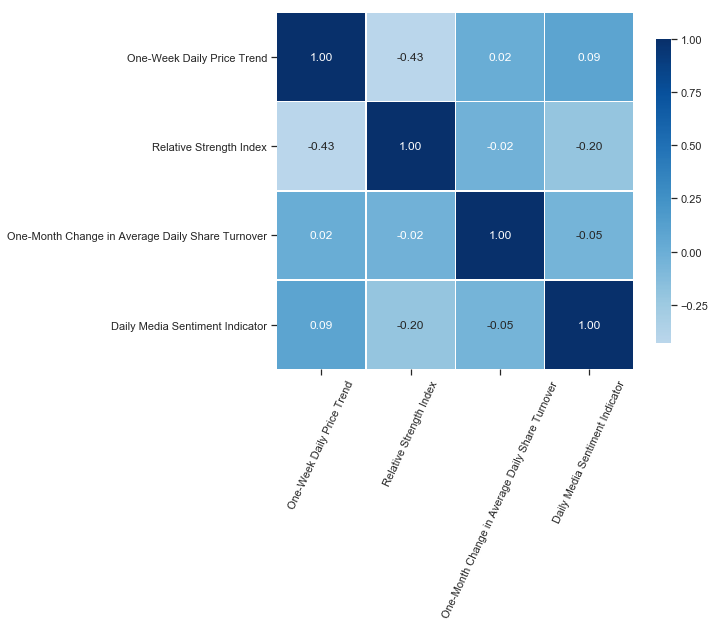

KeyError: 'Date'

In [43]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "AMZN"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=7) # training history window 
MODEL_NAME = 'LR'

selected_AMZN_tech_factors = AMZN_tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 
                                                      'One-Month Change in Average Daily Share Turnover', 
                                                       'Daily Media Sentiment Indicator']]

correlation_heatmap(selected_AMZN_tech_factors)

AMZN_tech_df = generate_NDayReturn(selected_AMZN_tech_factors, ticker_name, start_date, end_date, pred_day)

y_true, y_pred, test_dates = model_testing(AMZN_tech_df, test_date_start, history_window, pred_day, MODEL_NAME)
lr_performance = model_evalutation(y_true, y_pred, test_dates, MODEL_NAME, ticker_name)

### **History Window Test for AMZN**

history_window: 1 year	 acc: 0.316
history_window: 2 year	 acc: 0.331
history_window: 3 year	 acc: 0.348
history_window: 4 year	 acc: 0.391
history_window: 5 year	 acc: 0.402
history_window: 6 year	 acc: 0.398
history_window: 7 year	 acc: 0.408
history_window: 8 year	 acc: 0.383
history_window: 9 year	 acc: 0.383
history_window: 10 year	 acc: 0.378
history_window: 11 year	 acc: 0.367
history_window: 12 year	 acc: 0.398
history_window: 13 year	 acc: 0.404
history_window: 14 year	 acc: 0.400
history_window: 15 year	 acc: 0.393


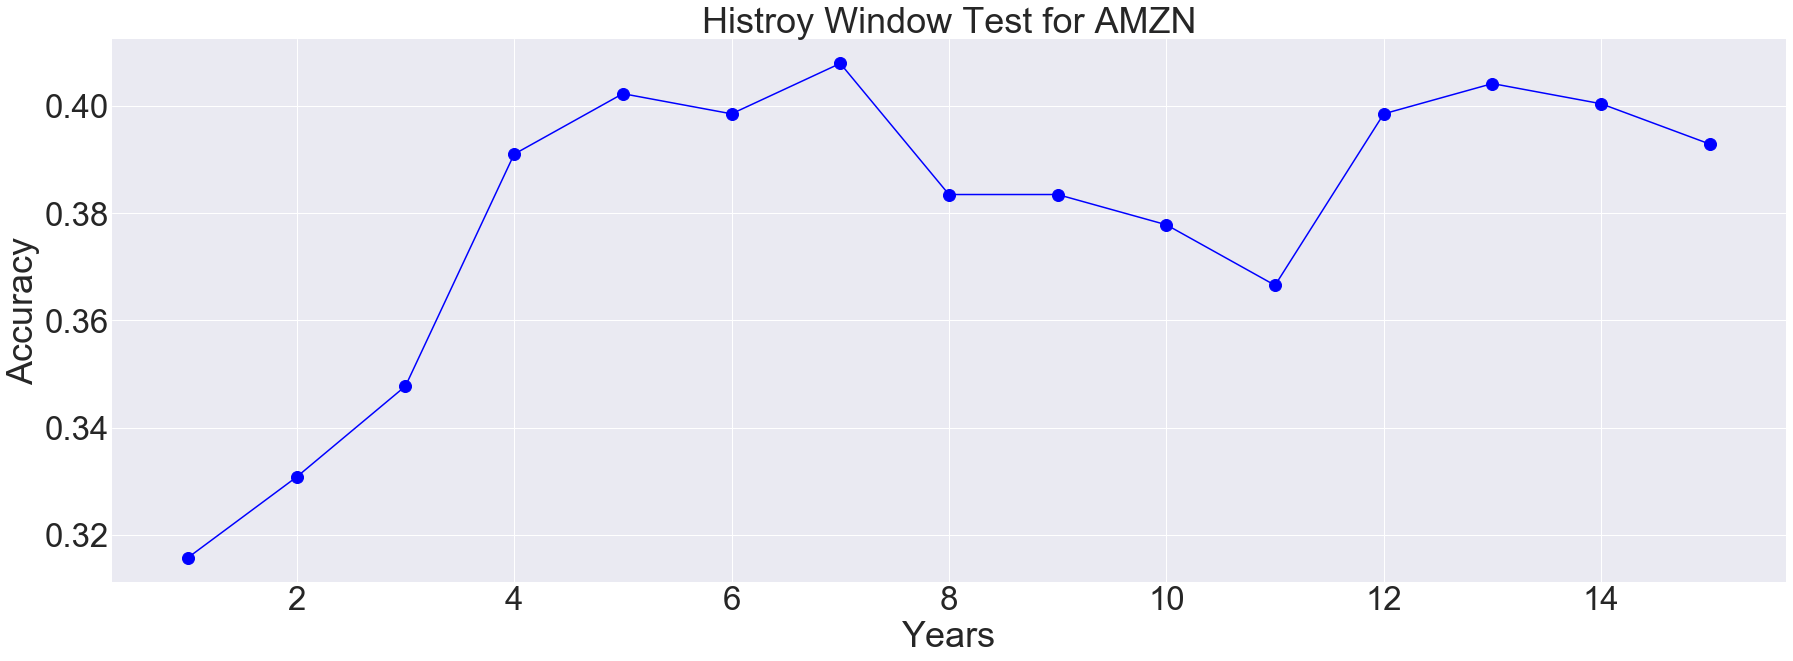

In [34]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "AMZN"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
MODEL_NAME = 'LR'

AMZN_tech_df = generate_NDayReturn(selected_AMZN_tech_factors, ticker_name, start_date, end_date, pred_day)


def history_window_test(tech_df, test_date_start, model_name):
    '''
    This function is to test the optimal history_window parameter.
    '''
    history_windows = list(range(1, 16))
    accuracies = []
    
    for hw in history_windows:
        history_window = relativedelta(years=hw) # training history window 
        y_true, y_pred, test_dates =model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        accuracy = accuracy_score(y_true, y_pred)
        print('history_window: {h} year\t acc: {a:.3f}'.format(h=hw, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(history_windows, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Histroy Window Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Years')
    plt.show()

history_window_test(AMZN_tech_df, test_date_start, MODEL_NAME)  

### **Rolliing Window Test for Price Trends for AMZN**

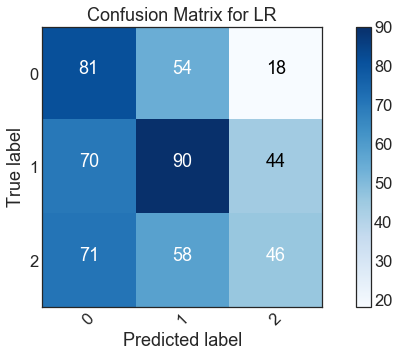

One-Week Daily Price Trend 	 acc: 0.408


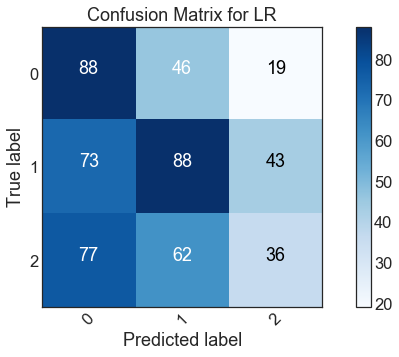

One-Month Daily Price Trend 	 acc: 0.398


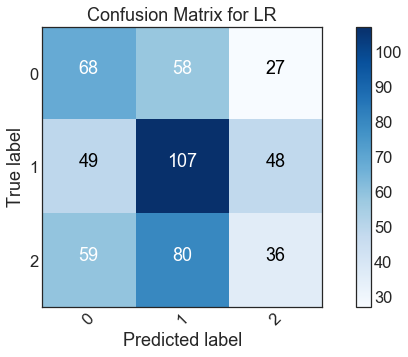

Three-Month Daily Price Trend 	 acc: 0.397


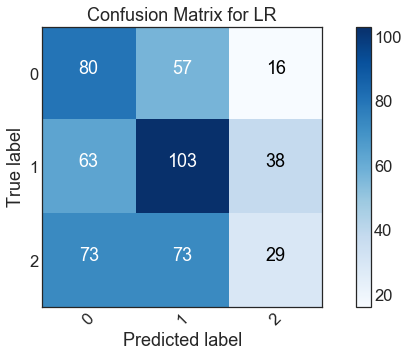

Nine-Month Daily Price Trend 	 acc: 0.398


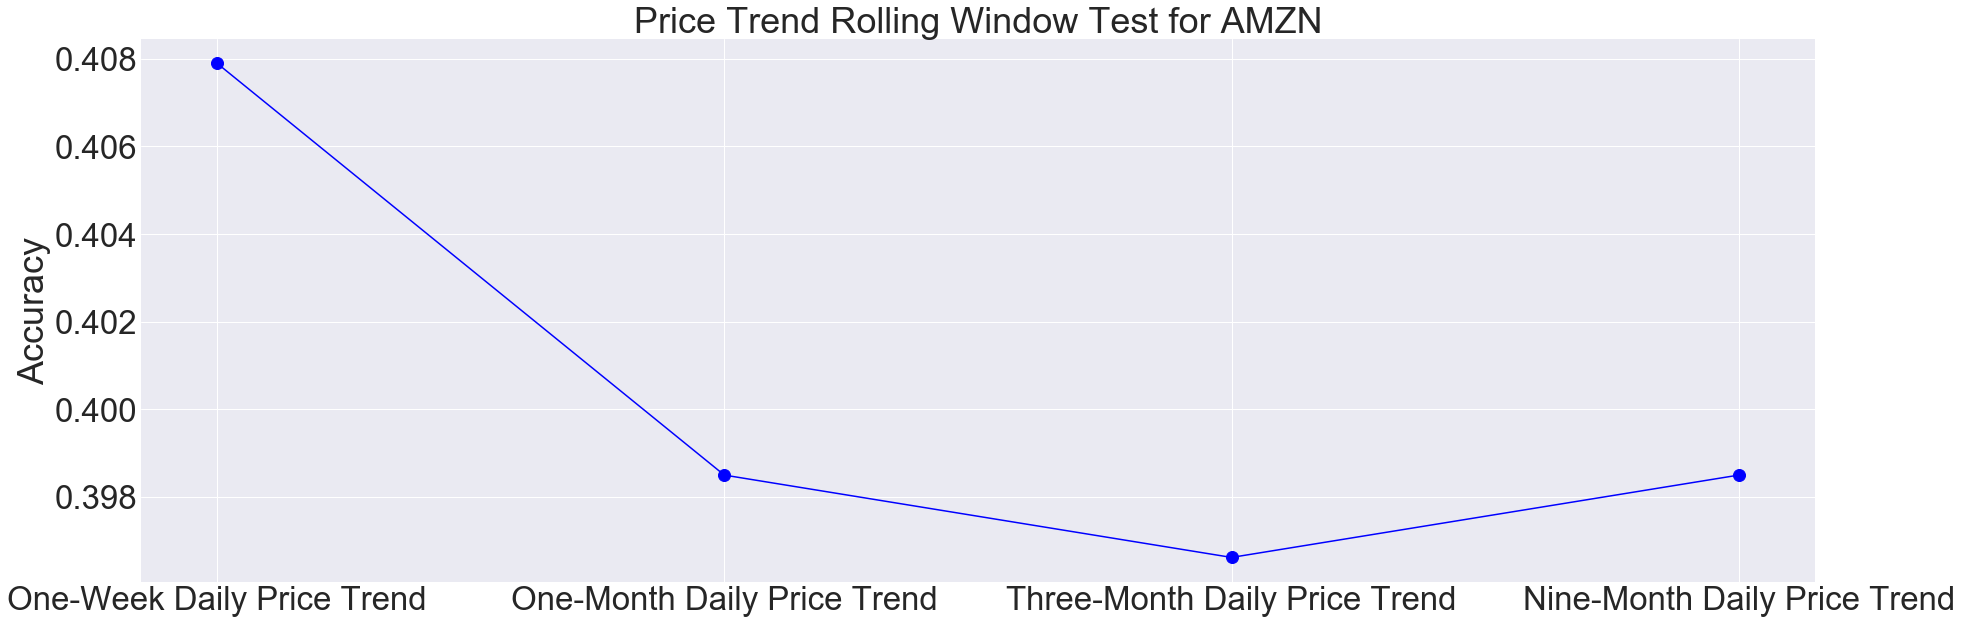

In [37]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "AMZN"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=7) # training history window 
MODEL_NAME = 'LR'

def price_trend_test(tech_factor_df, test_date_start, model_name):
    '''
    This function is to test the best rolling window for the price trend to use in the system. 
    '''
    price_trend = ['One-Week Daily Price Trend', 'One-Month Daily Price Trend', 'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend']
    accuracies = []
    
    for pt in price_trend: 
        selected_tech_factors = tech_factor_df[[pt, 'Relative Strength Index', 
                                                      'One-Month Change in Average Daily Share Turnover', 
                                                       'Daily Media Sentiment Indicator']]
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pred_day)
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(model_name))
        accuracy = accuracy_score(y_true, y_pred)
        print('{p} \t acc: {a:.3f}'.format(p=pt, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(price_trend, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Price Trend Rolling Window Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
#     plt.xlabel('Days')
    plt.show()

price_trend_test(AMZN_tech_factor_df, test_date_start, MODEL_NAME)  

### **Rolling Window Test for Downside Risk**

In [ ]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "AMZN"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=7) # training history window 
MODEL_NAME = 'LR'

def downside_risk_test(tech_factor_df, test_date_start, model_name):
    '''
    This function is to test the rolling window for for the downside risk factor to use.
    Since adding this factor will not improve the performance, so in the final model, downside risk is not used. 
    '''
    downside_risk = ['Downside Risk (Measured Over the Trailing Three Months)', 'Downside Risk (Measured Over the Trailing Nine Months)', 'Downside Risk (Measured Over the Trailing Twelve Months)']
    accuracies = []
    
    for dr in downside_risk: 
        selected_tech_factors = tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 'MACD Signal', 
                                                      'One-Month Change in Average Daily Share Turnover', 
                                                      'Technical Indicator', 'Daily Media Sentiment Indicator', dr]]
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pred_day)
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(model_name))
        accuracy = accuracy_score(y_true, y_pred)
        print('{d} \t acc: {a:.3f}'.format(d=dr, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (50, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(downside_risk, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Downside Risk Test for {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.show()

downside_risk_test(AMZN_tech_factor_df, test_date_start, MODEL_NAME) 

### **Predict Day Test for AMZN**

predict day: 1 days	 acc: 0.369


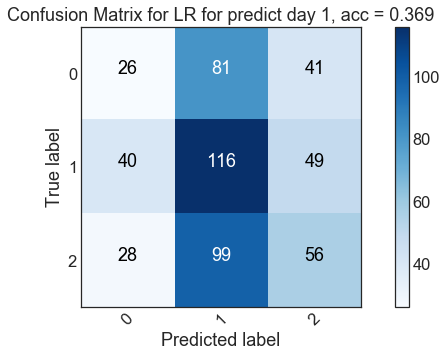

predict day: 2 days	 acc: 0.355


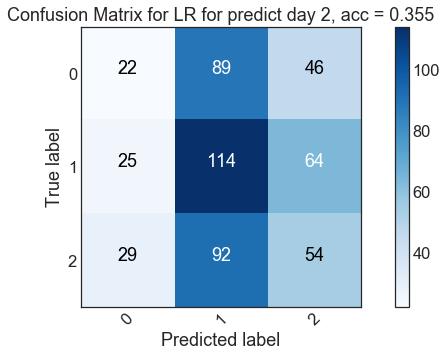

predict day: 3 days	 acc: 0.371


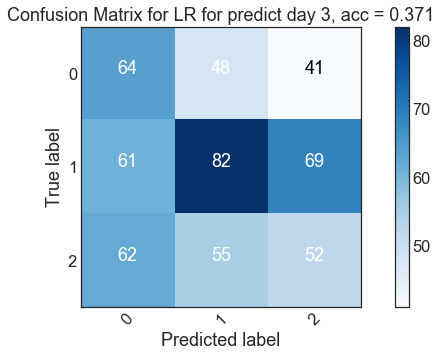

predict day: 4 days	 acc: 0.411


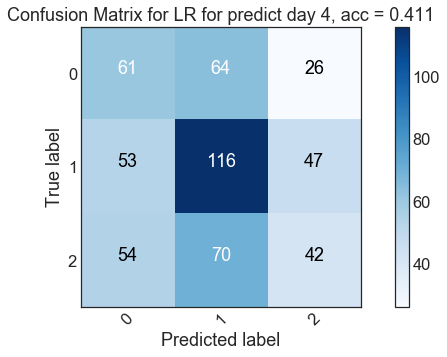

predict day: 5 days	 acc: 0.408


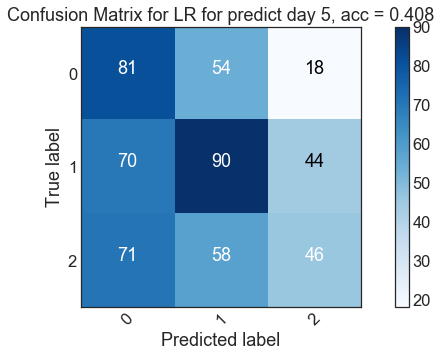

predict day: 10 days	 acc: 0.355


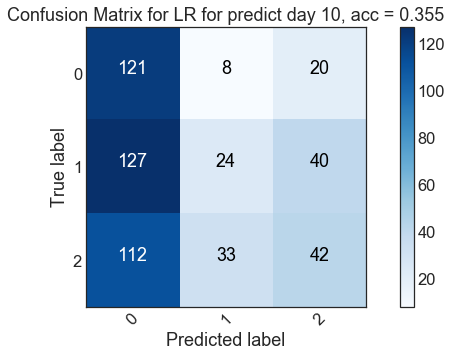

predict day: 15 days	 acc: 0.308


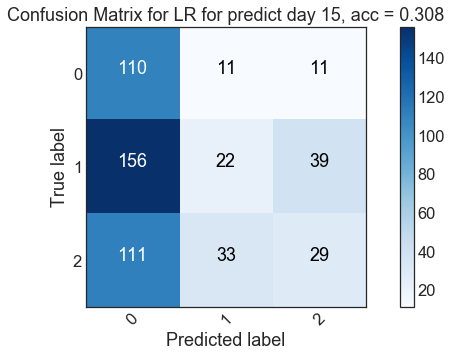

predict day: 20 days	 acc: 0.397


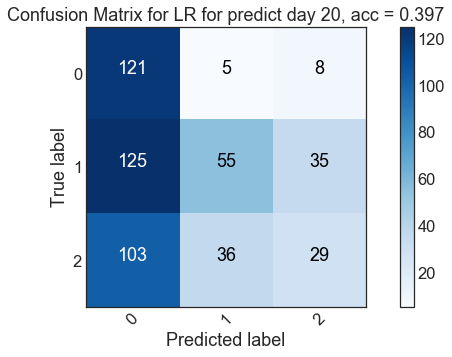

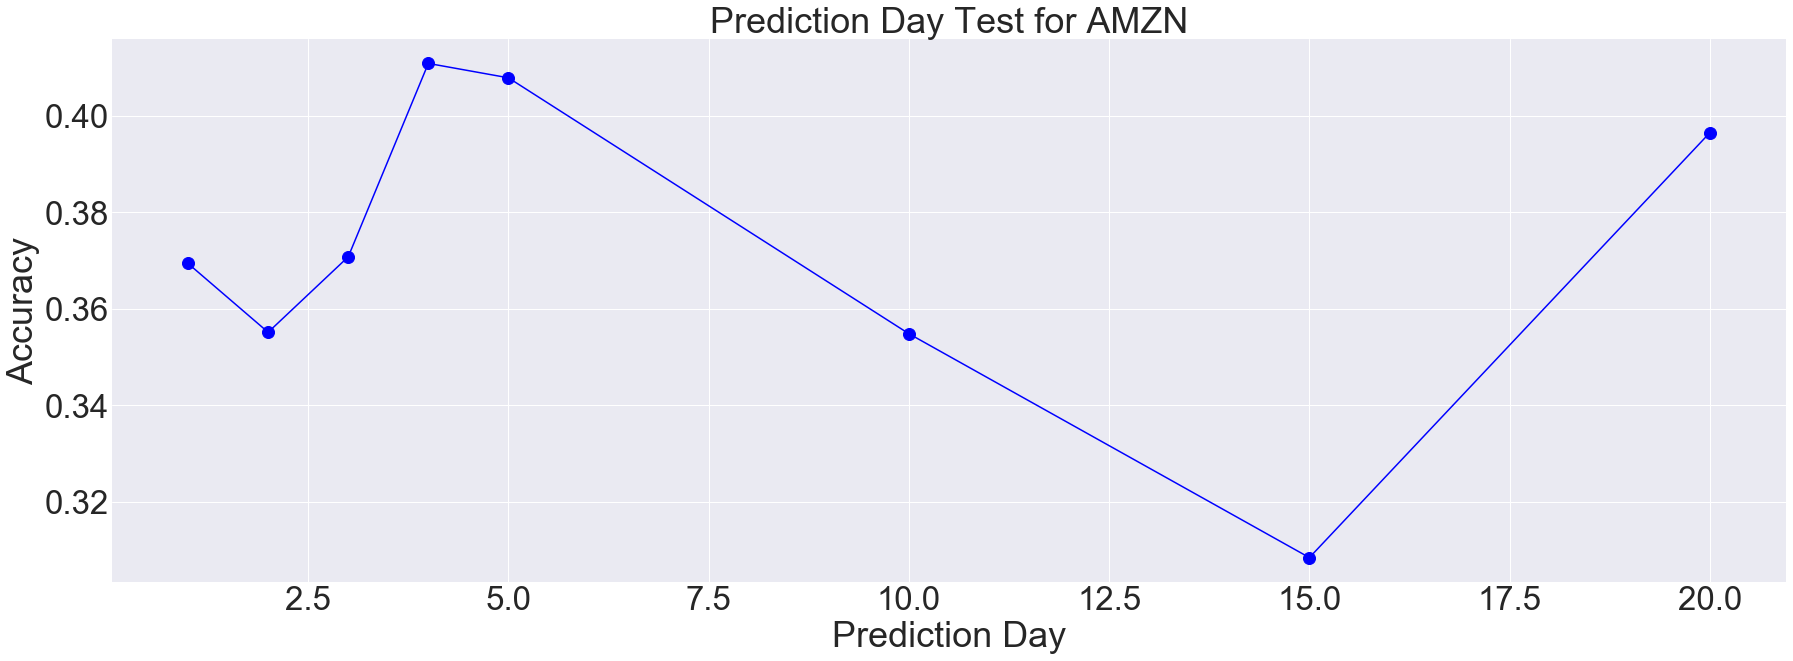

In [38]:
history_window = relativedelta(years=7) # training history window 
MODEL_NAME = 'LR'

def prediction_day_thresholds_test(selected_tech_factors, model_name):
    '''
    This function is to test the optimal predicted days. 
    '''
    pred_days = [1, 2, 3, 4, 5, 10, 15, 20]
    accuracies = []                           
    for pd in pred_days: 
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pd)    
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pd, model_name)
        accuracy = accuracy_score(y_true, y_pred) 
        print('predict day: {p} days\t acc: {a:.3f}'.format(p=pd, a=accuracy))
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {n} for predict day {p}, acc = {a:.3f}'.format(n=model_name, p=pd, a=accuracy ))
        accuracies.append(accuracy)
    
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(pred_days, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Prediction Day Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction Day')
    plt.show()

prediction_day_thresholds_test(selected_AMZN_tech_factors, MODEL_NAME)